## HW #2 Exercises

This month, we want to start thinking about reducing the linguistic complexity of our trial text. How can we process our text and turn it into a set of terms or n-grams?

#### Exercise 1

Now that we've gone through homework # 1, we have built a data structure with an appropriate set of labels and associated meta data.  Your thinking about the best way to model the data may have evolved after today's discussion. Think about, and build, the data structure that will best accomodate this model.

#### Exercise 2

It's a safe bet that after exercise 1, you still probably want to retain a large list of tokens from the text.
Using NLTK or SPACY, which elements of our trial data should we tokenize? Select the elements of our data structure we wish to tokenize and write code that will convert these elements into tokens. Should we store all tokens together, or maintain logical separation? What are the drawbacks of each of these choices?  Remember that we should have the ability to easily change how we tokenize these elements (1-grams, 2-grams, noun chunks, root words, etc) but choose the approach you think is most appropriate.

#### Exercise 3

Do you notice anything about your tokens? Are there a lot of seemingly useless or ambiguous tokens - what makes you think they are useless? Can you think of any ways to automate the removal of these useless tokens or to combine similar tokens? Add this into your code from part 1.

By the end of exercise 3 you should have a data structure that stores information for all trials, and includes some form of cleaned tokens for use in training or building our classifier.

In [1]:
# from hw1
import json
with open('NEW_clinical_trial_data.json','r') as f:
    data = json.load(f)
keys = list(data.keys())
mydata = {k:v for k,v in data.items() if v['is_visible'] and v['is_joinable']}
mykeys = list(mydata.keys())

to_include = ['nct_number','summary','summary_html','title_brief','title_official',
              'keywords','conditions','description_html',
              'eligibility_html','eligibility_inclusion_html','eligibility_exclusion_html',
              'links','eligibility_summary_short', 'is_visible','is_joinable']
# a dict of studies indexed by NCT number containing a dict of data fields
filtered = {k:{i:j for i,j in v.items() if i in to_include} for k,v in data.items()}

from bs4 import BeautifulSoup
# remove newlines, make all text lowercase
filtered = {k:{label:BeautifulSoup(term, 'html.parser').get_text().replace('\n',' ').lower() 
               if isinstance(term, str) else term
               for label,term in v.items()} 
            for k,v in filtered.items()}

import spacy
from tqdm import tqdm_notebook as tqdm
nlp = spacy.load('en_core_web_sm')
# or nltk.sent_tokenize()

# split long data fields into sentences
filtered_sent_tok = {k:{label:term.split('.') if isinstance(term, str) else term
               for label,term in v.items()} 
            for k,v in tqdm(filtered.items())}

# traverse the structure collecting all clusters, conditions, and cluster/condition pairs
# at the same time, add a field 'is_other' that labels studies belonging exclusively to the 'Other' cluster

conditions = set()
clusters = set()
pairs = set()
slugs_to_names = dict()
i = 0
for k,v in tqdm(filtered.items()):
    l_cond = v['conditions'] # a list of dicts
    for cond in l_cond:
        slugs_to_names[cond['slug']] = cond['name']
        conditions |= set([cond['slug']])
        clusters |= set(cond['clusters']) # a list
        pairs |= set('{}:{}'.format(cond['slug'], clust) for clust in cond['clusters'])
        if cond['clusters'] == ['Other']:
            v['is_other'] = True
    if 'is_other' not in v:
        v['is_other'] = False
#     if i<10:
#         print(k,[i for i in v])
#         i+=1

# collect text of each entry into one string
to_concat = ['summary','summary_html','title_brief','title_official',
              'keywords','description_html','eligibility_html','eligibility_inclusion_html',
             'eligibility_exclusion_html','eligibility_summary_short']
for k,v in filtered.items():
    v['full_text'] = ''
    for i in to_concat:
        v['full_text'] += v[i] if isinstance(v[i], str) else ', '.join(v[i])
        v['full_text'] += '. '

# label section headers as stopwords
nlp.Defaults.stop_words |= {i for i in to_concat}

# segment into other and non-other
train = []
for k,v in filtered.items():
    for condition in v['conditions']:
        for cluster in condition['clusters']:
            if 'Other' not in cluster:
                train.append((cluster, condition['slug'], v['full_text'], v))

test = [('Other',v['conditions'][0]['slug'], v['full_text'], v) 
        for k,v in filtered.items() if v['is_other']]
print(len(train), len(test))


6770 1515


In [2]:
# verify the data extraction, segment out a small test set
for ct,i in enumerate(train):
    if ct > 10: break
    print(i[0],i[1])
small = [j for i,j in enumerate(train) if i < 10]

Brain and Nerves neuropathy
Infectious Diseases hiv-aids
Infectious Diseases hiv-aids
Infectious Diseases hiv-aids
Infectious Diseases hiv-aids
Infectious Diseases hiv-aids
Mental Health alzheimers-disease
Brain and Nerves alzheimers-disease
Mental Health mild-cognitive-impairment
Bones, Joints, and Muscles osteoarthritis
Blood, Heart, and Circulation cardiovascular-disease


In [3]:
# initialize and train a TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def my_tok(a):
    # exclude stopwords, words with numbers, and words < 3 characters
    return [str(i) for i in nlp(a) if not i.is_stop and not 'd' in i.shape_ and len(i) >= 2]

vec = TfidfVectorizer(norm='l1', 
                      tokenizer=my_tok,  # function is required for pickling (lambdas don't pickle)
                      preprocessor=None, ngram_range=(1,1))

# small_tfidf = vec.fit_transform([i[2] for i in small])  # takes long time

import time
start = time.time()
print('start:', start)
tfidf = vec.fit_transform([i[2] for i in train])  # can take up to 1 hour
end = time.time()

tfidf_test = vec.transform([i[2] for i in test])

# print(tfidf)
# print('elapsed: ',end - start)

from math import floor
mins = (1539652327.9167979 - 1539649456.927396)/60.0
secs = 60*(mins - floor(mins))
print('elapsed: {}m {:.2f}s'.format(floor(mins), secs))

1540601225.145447
elapsed:  2697.76727104187
elapsed: 47m 50.99s


In [4]:
# save the model
from sklearn.externals import joblib
joblib.dump(vec, 'tfidf_vectorizer.joblib')
# vec = joblib.load('tfidf_vectorizer.joblib')

import scipy.sparse
scipy.sparse.save_npz('tfidf_of_train_data.npz', tfidf)
scipy.sparse.save_npz('tfidf_of_test_data.npz', tfidf_test)


In [2]:
# load saved model
import scipy.sparse
from sklearn.externals import joblib
from scipy.sparse.linalg import norm as s_norm

tfidf = scipy.sparse.load_npz('tfidf_of_train_data.npz')
vec = joblib.load('tfidf_vectorizer.joblib')
tfidf_test = scipy.sparse.load_npz('tfidf_of_test_data.npz')

/Users/jonrenslo/Documents/School/Postgrad/Arnaout_lab/Virtual_Dev_Environment/py3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jonrenslo/Documents/School/Postgrad/Arnaout_lab/Virtual_Dev_Environment/py3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
import numpy as np
from scipy.sparse.linalg import norm as s_norm

In [3]:
# rewrite in standard sklearn format
from tqdm import tqdm_notebook as tqdm
X = tfidf
X_test = tfidf_test    

if False:  # option to normalize tfidf vectors
    for i,v in enumerate(tqdm(X, total=X.shape[0])):
        X[i] /= np.sqrt(float((v @ v.transpose()).toarray()))  # s_norm(vec) is slightly slower
    for i,v in enumerate(tqdm(X_test, total=X_test.shape[0])):
        X_test[i] /= np.sqrt(float((v @ v.transpose()).toarray()))

y_term_list = list(set([i[0] for i in train]))
y_mapping = {k:n for n,k in enumerate(y_term_list)}
y = [y_mapping[i[0]] for i in train]
y_inverse_mapping = {v:k for k,v in y_mapping.items()}

In [9]:
# first naive approach: 
# use linear model to naively predict cluster from tf-idf of full text
"""
X b = y
b = X^-1 y
"""
import numpy as np
from scipy.linalg import inv
from scipy.sparse.linalg import inv as sparse_inv
y_expanded = np.array([[1 if i == j else 0 for j in range(len(y_term_list))] for i in y])
# todo: use svd to find pseudoinverse to get manual linear model ?
# see scipy.sparse.linalg for solvers of Ax = b


In [10]:
# second naive approach:
# calculate average vectors for each cluster and use dot-product similarity as baseline/naive classifier
# todo: try compressing tfidf into smaller-dimension (SVD) space 
import numpy as np

tfidf_lists = [[] for i in y_term_list]
for vec, label in zip(X,y):
    tfidf_lists[label].append(vec)
total = 0
print('Studies per class')
[print('{:<40}{:>4}'.format(j, len(i))) for i,j in zip(tfidf_lists, y_term_list)]
print('{:<40}{:>4}'.format('Total Studies', sum(len(i) for i in tfidf_lists)))

tfidf_lists = [scipy.sparse.vstack(j) for j in tfidf_lists]  # convert to matricies from lists of vectors
avgs = [j.mean(axis=0) for j in tfidf_lists]  # calculate average vectors
avgs = scipy.vstack(i[0] for i in avgs)  # stack the vectors into a matrix (rows=classes, cols=vocab)

def avg_class(vec, class_matrix=avgs, label_lookup=y_inverse_mapping):
    # the class-coherence vector is the matrix-product with a tfidf vector (dot-product score)
    # returns (label, score vector) or (index, score vector) if label_lookup is None
    try:
        scores = class_matrix @ vec
    except ValueError:
        scores = class_matrix @ vec.transpose()
        
    norms = scipy.vstack([class_matrix[i] @ class_matrix[i].transpose() for i in range(class_matrix.shape[0])])
    norms *= float((vec @ vec.transpose()).toarray())
    scores = scores / np.sqrt(norms)
    
    return label_lookup[scores.argmax()] if label_lookup else scores.argmax(), scores

# evaluate on train set
naive_predict = [avg_class(i, label_lookup=None)[0] for i in X]

# calculate accuracy score
def acc(test, true=np.array(y)):
    if isinstance(test, type(np.array([]))):  # coerce to numpy array
        return (true ==  test).sum() * 1.0/len(true)
    else:
        return (true ==  np.array(test)).sum() * 1.0/len(true)

print('avgvector', acc(naive_predict))
print('allcancer', acc(np.array([y_mapping['Cancer']] * len(y))))
print('randchoice', acc(np.random.randint(0, len(y_term_list), len(y))))

Studies per class
Digestive System                         250
Cancer                                  3053
Metabolic Problems                       310
Blood, Heart, and Circulation            485
Diagnostic Tests                           2
Multisystem Disorders                      7
Tumors                                   155
Brain and Nerves                         434
Respiratory Diseases                       3
Eyes and Vision                           49
Mouth and Teeth                            9
Organ and Tissue Transplant              145
Drug Dependence and Related Disorders     78
Lungs and Breathing                      127
Immune System                             47
Injuries                                  99
Mental Health                            224
Genetics and Birth Defects                76
Infectious Diseases                      739
Ear, Nose, and Throat                      8
Skin Disorders                            23
Bones, Joints, and Muscles           

In [11]:
# compare to stock models
import sklearn
import sklearn.linear_model
reg = sklearn.linear_model.LogisticRegression(solver='newton-cg', random_state=0, tol=1e-8, 
                         max_iter=1000, multi_class='multinomial', warm_start=True).fit(X,y)
# gives error, line-search failed. perhaps the model fitting does not work on this data
print('LogReg', reg.score(X, y))
linsvc = sklearn.svm.LinearSVC(random_state=0).fit(X, y)
print('linsvc', linsvc.score(X, y))
knn = sklearn.neighbors.KNeighborsClassifier(n_jobs=4).fit(X, y)
print('knn', knn.score(X, y))
w_knn = sklearn.neighbors.KNeighborsClassifier(weights='distance', n_jobs=4).fit(X, y)
print('weighted knn', w_knn.score(X, y))

LogReg 0.8149187592319055
linsvc 0.834711964549483
knn 0.8072378138847858
weighted knn 0.8335302806499262


In [12]:
# Calculate test predictions
probs = reg.predict_proba(X_test)
svc_labels = linsvc.predict(X_test)
knn_probs = knn.predict_proba(X_test)
avg_labels = [avg_class(i)[0] for i in X_test]
w_knn_probs = w_knn.predict_proba(X_test)

# Translate to human-readable labels
pred_i = [list(i).index(max(i)) for i in probs]
labels = [y_inverse_mapping[i] for i in pred_i]

labels_svc = [y_inverse_mapping[i] for i in svc_labels]

pred_knn = [list(i).index(max(i)) for i in knn_probs]
labels_knn = [y_inverse_mapping[i] for i in pred_knn]

pred_w_knn = [list(i).index(max(i)) for i in w_knn_probs]
labels_w_knn = [y_inverse_mapping[i] for i in pred_w_knn]

# Assemble results
import pandas as pd
df_train = pd.DataFrame(train, columns=['Cluster','Condition','text', 'data'])
df_train['log_reg_predict'] = [y_inverse_mapping[i] for i in reg.predict(X)]
df_train['svc_predict'] = [y_inverse_mapping[i] for i in linsvc.predict(X)]
df_train['knn_predict'] = [y_inverse_mapping[i] for i in knn.predict(X)]
df_train['avg_labels'] = [y_inverse_mapping[i] for i in naive_predict]
df_train['wknn_predict'] = [y_inverse_mapping[i] for i in w_knn.predict(X)]
df_train['dataset'] = 'train'

df_test = pd.DataFrame(test, columns=['Cluster','Condition','text', 'data'])
df_test['log_reg_predict'] = labels
df_test['svc_predict'] = labels_svc
df_test['knn_predict'] = labels_knn
df_test['avg_labels'] = avg_labels
df_test['wknn_predict'] = labels_w_knn
df_test['dataset'] = 'test'

df = df_train.append(df_test, sort=False)
df.reset_index(inplace=True)
df['nct_number'] = [row['data']['nct_number'] for i, row in df.iterrows()]

In [4]:
# plot to visualize trial spread/clusters
from sklearn.manifold import TSNE
from sklearn.decomposition.truncated_svd import TruncatedSVD
decomp_p = TruncatedSVD(random_state=1, n_iter=20)
X_trans = decomp_p.fit_transform(X)
decomp = TruncatedSVD(50, random_state=1)
X_svd = decomp.fit_transform(X)

In [5]:
%matplotlib inline
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt
plt.switch_backend('tkagg')
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns

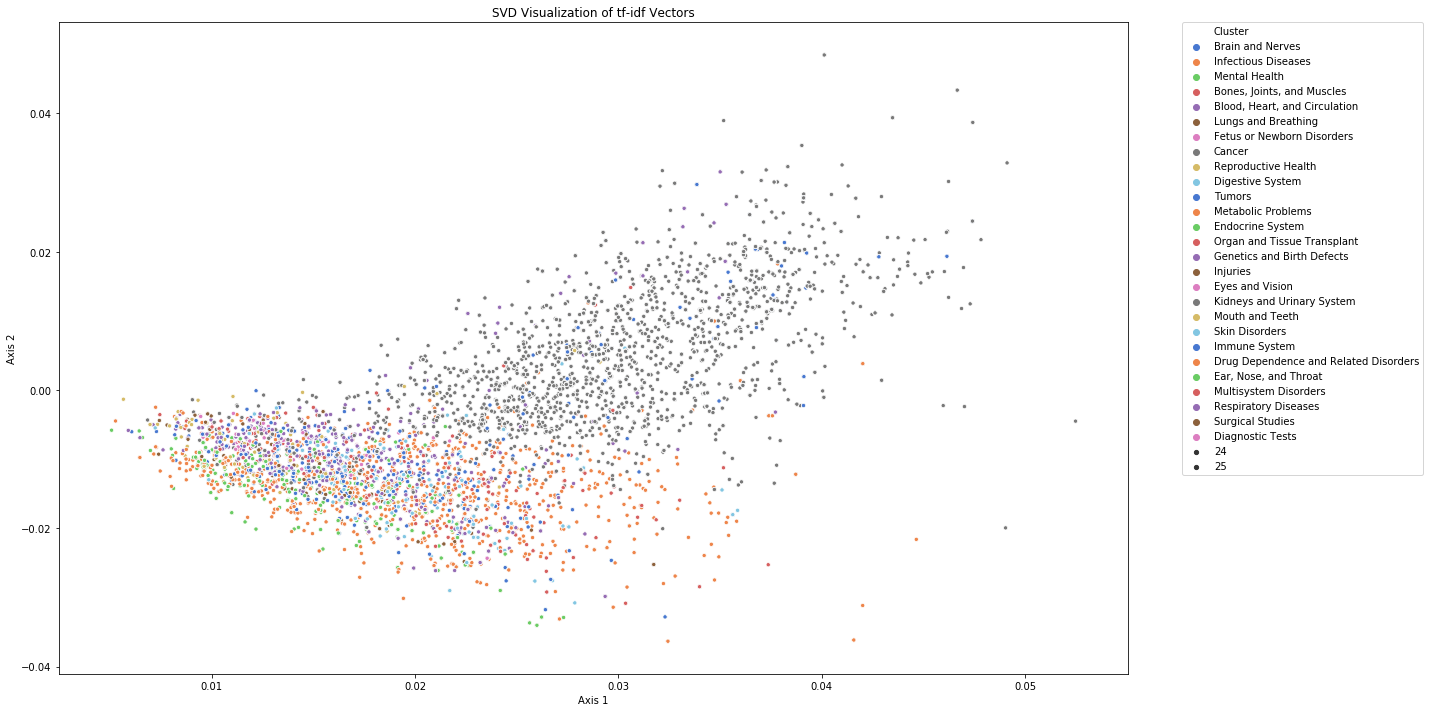

In [21]:
yy = pd.Series(y)
# yy.value_counts()  # 27 unique labels to color
cmap = cm.ScalarMappable(cmap=cm.Set1)
cmap.set_array(y)
colors = cmap.to_rgba(range(len(yy.unique())))

to_plot = list(zip(*X_trans))
plt.figure()
plt.gcf().set_size_inches((20,10))
to_plot = pd.DataFrame([to_plot[0], to_plot[1], y]).T
to_plot.columns = ['Axis 1','Axis 2','cls']
to_plot['Cluster'] = to_plot.cls.map(y_inverse_mapping)
# arts = list()
# for i in to_plot.cls.unique():
#     arts.append(plt.scatter(to_plot[to_plot.cls == i].loc[:,'x'], to_plot[to_plot.cls == i].loc[:,'y'], marker='.', 
#                 color=colors[int(i)]))
# for i in range(1, len(yy.unique())):
#     plt.plot(0,'.')
# plt.legend(arts, [y_inverse_mapping[i] for i in range(len(yy.unique()))], loc='best')
# plt.legend()
sns.scatterplot(x='Axis 1', y='Axis 2', hue='Cluster', data=to_plot, 
                size=[25 for i in range(to_plot.shape[0])], 
                palette=sns.color_palette('muted', n_colors=27))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('SVD Visualization of tf-idf Vectors')
plt.tight_layout()
plt.savefig('svd.png')
plt.savefig('svd.svg')

In [7]:
# plt.figure()
# ind=3
# plt0 = to_plot[to_plot.cls == ind]
# plt.scatter(plt0.x, plt0.y, marker='.', color=colors[int(ind)])

In [8]:
%%time
tsne = TSNE(random_state=1, init='pca')
out = tsne.fit_transform(X_svd)
to_plot_tsne = list(zip(*out))

CPU times: user 57.3 s, sys: 2.72 s, total: 1min
Wall time: 1min


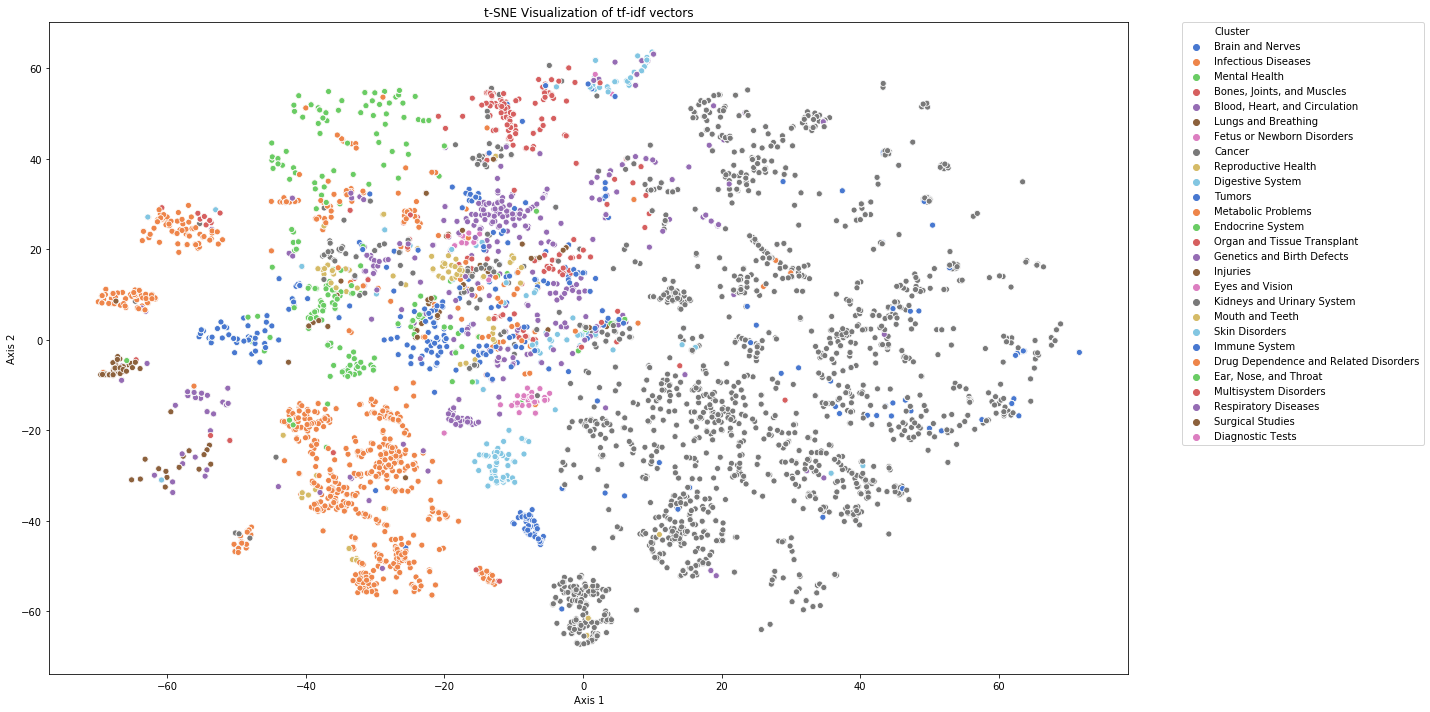

In [22]:
plt.figure()
df_tsne = pd.DataFrame(to_plot_tsne, index=['Axis 1', 'Axis 2']).T
# print(df_tsne.shape, len(y))
df_tsne['Cluster'] = [y_inverse_mapping[i] for i in y]
sns.scatterplot(x='Axis 1', y='Axis 2', data=df_tsne, hue='Cluster',palette=sns.color_palette('muted', n_colors=27))
plt.title('t-SNE Visualization of tf-idf vectors')
plt.gcf().set_size_inches((20,10))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('tsne.png')
plt.savefig('tsne.svg')

In [ ]:
from tqdm import tqdm
%matplotlib inline
df_svd = to_plot
to_plot.columns = ['Axis 1', 'Axis 2','cls','Cluster']

In [25]:
for df,label in zip((df_tsne, to_plot),('t-SNE','SVD')):
    plt.close('all')
    for i in tqdm(df['Cluster'].unique()):
        df['Callout'] = (df['Cluster'] == i).map({True:0, False:1})
        plt.figure()
        sns.scatterplot(x='Axis 1', y='Axis 2', data=df, hue='Cluster',
                        size=df['Callout'], sizes=(15,90 if df[df['Cluster'] == i].shape[0] > 10 else 300), 
                        palette=sns.color_palette('muted', n_colors=27))
        plt.title('{} Visualization of tf-idf vectors'.format(label))
        plt.gcf().set_size_inches((15,10))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        plt.savefig('{}-{}.png'.format(label, i))
        plt.savefig('{}-{}.svg'.format(label, i))
        plt.close()


100%|██████████| 27/27 [01:38<00:00,  3.66s/it]

100%|██████████| 27/27 [02:13<00:00,  5.72s/it]


In [13]:
# Prepare csv export
df_out = df.drop('data', axis=1)
max_len = 2**15 - 9  # maximum data length in an excel cell, in doc 2**15-1, empirically, less
df_out['trunc_text'] = df_out['text'].apply(
    lambda a: a.replace('\n','|n').replace(',',';').replace('\r','|r')[max_len:] if len(a) > max_len else None)
df_out['text'] = df_out['text'].apply(
    lambda a: a.replace('\n','|n').replace(',',';').replace('\r','|r')[:max_len])
df_out.to_csv('stock_predictions.csv')

In [14]:
df[df.dataset == 'test'][['Cluster','Condition','text','log_reg_predict','svc_predict','knn_predict','avg_labels','nct_number']]

,Cluster,Condition,text,log_reg_predict,svc_predict,knn_predict,avg_labels,nct_number
6770,Other,hiv-aids,to compare the relative merits of three therap...,Infectious Diseases,Infectious Diseases,Infectious Diseases,Infectious Diseases,nct00000134
6771,Other,hiv-aids,to evaluate the relative safety and efficacy o...,Infectious Diseases,Infectious Diseases,Infectious Diseases,Infectious Diseases,nct00000136
6772,Other,keratitis-herpetic,to determine whether early treatment (with ora...,Infectious Diseases,Eyes and Vision,Infectious Diseases,Eyes and Vision,nct00000139
6773,Other,hiv-aids,to test and evaluate the efficacy and safety o...,Infectious Diseases,Infectious Diseases,Infectious Diseases,Infectious Diseases,nct00000142
6774,Other,cytomegalovirus-retinitis,"to compare the newest cmv retinitis drug, cido...",Infectious Diseases,Infectious Diseases,Infectious Diseases,Infectious Diseases,nct00000143
6775,Other,hiv-aids,"to monitor trends over time, in the incidence ...",Infectious Diseases,Infectious Diseases,Infectious Diseases,Infectious Diseases,nct00000168
6776,Other,spondylolisthesis,this study tests the effectiveness of differen...,"Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles",nct00000409
6777,Other,herniated-disc,this study tests the effectiveness of differen...,"Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles",nct00000410
6778,Other,spinal-stenosis,this study tests the effectiveness of differen...,"Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles",nct00000411
6779,Other,spondylitis-ankylosing,the division of rheumatology at university of ...,"Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles","Bones, Joints, and Muscles",nct00000433


In [13]:
n = []
for i in tqdm(X, total=X.shape[0]):
    n.append(np.sqrt(float((i @ i.transpose()).toarray())))

import pandas as pd
n = pd.Series(n)
print(n.describe())

# it appears the tfidf vectors have very small norm. Perhaps should try normalizing them?
# ...
# If we do, performance bumps up from ~60-70% to >80% for the stock models! (see the if True option above)


count    6770.000000
mean        0.102447
std         0.030100
min         0.048849
25%         0.080892
50%         0.098383
75%         0.118460
max         0.308061
dtype: float64


In [106]:
df.iloc[6770,3][:2000]
# it seems that studies from clinicaltrials.gov have entered into our dataset... 

'to compare the relative merits of three therapeutic regimens in patients with aids and cmv retinitis who have been previously treated but whose retinitis either is nonresponsive or has relapsed. these three therapeutic regimens were (1) foscarnet, (2) high-dose ganciclovir, and (3) combination foscarnet and ganciclovir. to compare two treatment strategies in patients with relapsed or nonresponsive cmv retinitis: (1) continuing the same anti-cmv drug or (2) switching to the alternate drug.to compare the relative merits of three therapeutic regimens in patients with aids and cmv retinitis who have been previously treated but whose retinitis either is nonresponsive or has relapsed. these three therapeutic regimens were (1) foscarnet, (2) high-dose ganciclovir, and (3) combination foscarnet and ganciclovir. to compare two treatment strategies in patients with relapsed or nonresponsive cmv retinitis: (1) continuing the same anti-cmv drug or (2) switching to the alternate drug.studies of th

ideas:
- use pre-trained embeddings to distinguish words/reports further
- expand training set with clinicaltrials.gov data
- do two stage model with supervised learning after first system tags

In [30]:
mytestvec = vec.transform(['heart '*20 + 'blood ' * 20])
m = reg.predict_proba(mytestvec)[0]

for i,j in enumerate(sorted(zip(m, y_term_list), reverse=True)):
    print('{:<40} {:>20.5f}'.format(j[1], j[0])) if i < 10 else None

m_norm = reg.predict_proba(mytestvec / np.sqrt(float((mytestvec @ mytestvec.transpose()).toarray())))[0]
print('\nNormalized vector:\n')
for i,j in enumerate(sorted(zip(m_norm, y_term_list), reverse=True)):
    print('{:<40} {:>20.5f}'.format(j[1], j[0])) if i < 10 else None

Blood, Heart, and Circulation                         0.75271
Cancer                                                0.05021
Infectious Diseases                                   0.02835
Metabolic Problems                                    0.01855
Brain and Nerves                                      0.01720
Reproductive Health                                   0.01376
Mental Health                                         0.01205
Digestive System                                      0.01169
Endocrine System                                      0.01066
Kidneys and Urinary System                            0.00917

Normalized vector:

Blood, Heart, and Circulation                         0.90250
Cancer                                                0.02008
Infectious Diseases                                   0.01048
Metabolic Problems                                    0.00745
Brain and Nerves                                      0.00603
Reproductive Health                              

Because cancer trials have so many more conditions/tags, our training set has a disproportionate number of cancer-clustered trials. This makes the prediction weighted heavily towards cancer (to the point where some preliminary naive models predicted ALL the test-set trials as cancer-clustered). 

In [84]:
import pandas as pd
pd.Series([y_inverse_mapping[i] for i in y]).value_counts().head(10)

Cancer                           3053
Infectious Diseases               739
Blood, Heart, and Circulation     485
Brain and Nerves                  434
Metabolic Problems                310
Digestive System                  250
Mental Health                     224
Endocrine System                  157
Tumors                            155
Organ and Tissue Transplant       145
dtype: int64

### HW #3 

This month, we are focusing on transforming our text based data structure into a numeric one for use in one of several models (see the project overview flow chart). This numeric data structure is often referred to as a "document term matrix" and allows us to represent each document (ie - a trial, condition and cluster combination) as a vector. The collection of all of these documents gives us a matrix that we can use for modeling purposes.

Encoding this text based data into vector form is done in a few different ways, but we will look into weighting techniques for building our numeric dataset. Typically this is done by representing each document by a single vector drawn from a vector space that spans the vocabularly defined within our document pool. Each of the components of this vector are some form of normalized or unnormalized word frequencies. How we define these frequencies is problem specific, but the most common scheme is referred to as TF-IDF. Here is some more information on this technique:

 - https://en.wikipedia.org/wiki/Tf%E2%80%93idf
 - http://ishwortimilsina.com/vector-space-model

Once you've seen the project overview flow chart and read the above URLs, take a look at the Week 3 Vectorization Activity. Print it out if you can, this simple activity will give you a much stronger intuition for the types of vectorization schemes available.

After the last homework, you should have a pretty well defined analytic data structure that links a specific condition and trial text with other features (if desired) to a cluster. It should be pretty easy to split those into "other" clusters and our "training" set of clusters. See the jupyter notebook called "HW 2 Solutions" for more information about this process.

Next, we need to build our document-term matrix for use in modeling. The easiest way to do this is in Python to use the Sklearn TfidfVectorizer (as seen here https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af and here http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) on the full text (however you define that) for each document. This takes a step back from our tokenized words, but shows us the power of keeping all of that data around. For more info see: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

For this month's homework, please build the document term matrix for your training data. For this, each row should be 1 document (ie - a single Trial-condition combination) and each column will be one term from the corpus (ie - one of the words from the entire vocabulary used for all of our documents). Be sure to use one of sklearn's (or another python package) functions for doing this, as it will simplify your life immensely. 

Finally, there has been a slight update to the JSON data. I'm including it for reference as it is what I will be using, but you can continue to use the original version if that makes more sense for you.

multiindex rows with the condition/cluster

### HW #3 Extension

To extend this homework, we need to think about how we want to represent the conditions. To me, it seems like the conditions are very important features. We probably do not just want to use them as additional text. We may want to build indicator variables using them, but their dimensionality is huge, and that will probably hurt our model. How might we use the conditions in our model? My guess is that one of the NLM ontologies will be a big help here: MeSH or UMLS

1. clean with ontology tagging/thesauraus
2. condense/hash into a feature (?)
    - use as a weighted term, add to tf-idf?
    - make indicators
    - make a single axis categorical var
    - ...?

['BeautifulSoup',
 'In',
 'Out',
 'X',
 'X_test',
 '_',
 '_10',
 '_11',
 '_17',
 '_18',
 '_21',
 '_22',
 '_23',
 '_24',
 '_25',
 '_29',
 '_30',
 '_5',
 '_7',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'acc',
 'avg_class',
 'avgs',
 'cluster',
 'clusters',
 'cond',
 'condition',
 'conditions',
 'data',
 'exit',
 'f',
 'filtered',
 'filtered_sent_tok',
 'get_ipython',
 'i',
 'joblib',
 'json',
 'k',
 'keys',
 'l_cond',
 'label',
 'mydata',
 'mykeys',
 'n',
 'naive_predict',
 'nlp',
 'np',
 'pairs',
 'pd',
 'quit',
 'scipy',
 'slugs_to_names',
 'spacy',
 'sqrt',
 'test',
 'tfidf',
 'tfid